In [3]:
################################################################
#              Aknowledgements                                 #
################################################################
# This notebook takes inspriration from the following work    #
# of kaggle user Black Mamba                                  #
# https://www.kaggle.com/theblackmamba31/who-is-behind-the-mask
#                                                             #
# do upvote her work                                          #
###############################################################


###############################################################
#  This noteBook contains a Transformer for image Segmentation#
###############################################################

In [2]:
## Making essential imports
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import keras
from layer import *
from attention_module import *
from CARUNet import *

In [3]:
print(tf.__version__)

2.10.0


In [4]:
## defining a frame for image and mask storage
framObjTrain = {'img' : [],
           'mask' : []
          }

framObjValidation = {'img' : [],
           'mask' : []
          }

## defining data Loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    maskNames = []
    
    ## generating mask names
    for mem in imgNames:
        maskNames.append(re.sub('\.png', '_L.png', mem))
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(imgNames)):
        img = plt.imread(imgAddr + imgNames[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        
    return frameObj

In [5]:
framObjTrain = LoadData( framObjTrain, imgPath = r"CamVid\train", maskPath = r"CamVid\train_labels"
         , shape = 256)

In [6]:
framObjValidation  = LoadData( framObjValidation, imgPath = r'CamVid\val', maskPath = r'CamVid\val_labels'
         , shape = 256)

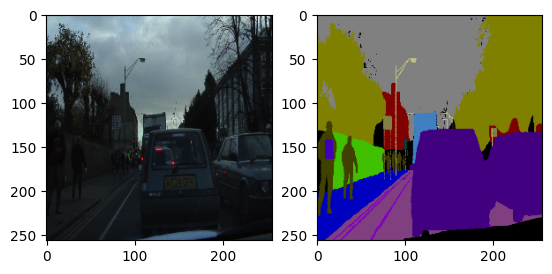

In [7]:
## displaying data loaded by our function
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.show()

In [8]:
framObjTrain['img'][1].shape

(256, 256, 3)

In [9]:
framObjTrain['mask'][1].shape

(256, 256, 3)

In [10]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
def meca_block(input_feature, k_size=3):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]

    shared_layer_one = Conv1D(filters=1,kernel_size=k_size,strides=1,kernel_initializer='he_normal',use_bias=False,padding="same")


    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    assert avg_pool.shape[1:] == (1, 1, channel)
    avg_pool = Permute((3, 1, 2))(avg_pool)
    avg_pool = Lambda(squeeze)(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = Lambda(unsqueeze)(avg_pool)
    avg_pool = Permute((2, 3, 1))(avg_pool)
    assert avg_pool.shape[1:] == (1, 1, channel )


    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    assert max_pool.shape[1:] == (1, 1, channel)
    max_pool = Permute((3, 1, 2))(max_pool)
    max_pool = Lambda(squeeze)(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = Lambda(unsqueeze)(max_pool)
    max_pool = Permute((2, 3, 1))(max_pool)
    assert max_pool.shape[1:] == (1, 1, channel)


    eca_feature = Add()([avg_pool, max_pool])
    eca_feature = Activation('sigmoid')(eca_feature)

    if K.image_data_format() == "channels_first":
        eca_feature = Permute((3, 1, 2))(eca_feature)

    return multiply([input_feature, eca_feature])
def unsqueeze(input):
    return K.expand_dims(input,axis=-1)

def squeeze(input):
    return K.squeeze(input,axis=-1)

In [12]:
# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = keras.layers.BatchNormalization()(x)
        
    x =keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = keras.layers.BatchNormalization()(x)
        
    x = keras.layers.Activation('relu')(x)
    
    return x


# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    ca1 = meca_block(c1)
    p1 = keras.layers.MaxPooling2D((2,2))(c1)
    p1 = keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    ca2 = meca_block(c2)
    p2 = keras.layers.MaxPooling2D((2,2))(c2)
    p2 = keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    ca3 = meca_block(c3)
    p3 = keras.layers.MaxPooling2D((2,2))(c3)
    p3 = keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    ca4 = meca_block(c4)
    p4 = keras.layers.MaxPooling2D((2,2))(c4)
    p4 = keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = keras.layers.concatenate([u6, ca4])
    u6 = keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = keras.layers.concatenate([u7, ca3])
    u7 = keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = keras.layers.concatenate([u8, ca2])
    u8 = keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = keras.layers.concatenate([u9, ca1])
    u9 = keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = keras.layers.Conv2D(32, (1, 1), activation = 'softmax')(c9)
    model = keras.Model(inputs = [inputImage], outputs = [output])
    return model

## instanctiating model
inputs = keras.layers.Input((256, 256, 3))
myTransformer = GiveMeUnet(inputs, droupouts= 0.07)
myTransformer.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'] )

In [13]:
myTransformer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [14]:
from tensorflow import keras
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="Unet_attention",
        save_best_only=True,
        monitor="val_loss")
]


In [15]:
#convert mask to class
label = pd.read_csv('CamVid/class_dict.csv',usecols=[1,2,3])

rgb_dict = {}
for i in range(32) :
    rgb_dict[ i ] = (label.iloc[i,0],label.iloc[i,1],label.iloc[i,2])
label = label.to_numpy().reshape((32,3))


def RGBtolabel(RGB,label) :
    number = np.linalg.norm(RGB - label,axis=1).argmin()
    return number 
def labeltoRGB(rgb_dict,label) :
    rgb = rgb_dict[label]
    return  np.array( rgb)

In [16]:
train_mask_rgb = np.array(framObjTrain['mask'])*255
train_mask_class = np.empty((369,256,256,1))

for k in range(369) : #img #
    for i in range(256) : 
        for j in range(256) : #get rgb pixels
            train_mask_class[k,i,j] = (RGBtolabel(train_mask_rgb[k][i][j],label))

In [17]:
val_mask_rgb = np.array(framObjValidation['mask'])*255
val_mask_class = np.empty((100,256,256,1))

for k in range(100) : #img #
    for i in range(256) : 
        for j in range(256) : #get rgb pixels
            val_mask_class[k,i,j] = (RGBtolabel(val_mask_rgb[k][i][j],label))

In [18]:
## trainign our model
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
retVal = myTransformer.fit(np.array(framObjTrain['img']), train_mask_class, epochs = 150,validation_data=(np.array(framObjValidation['img']),val_mask_class),callbacks=callbacks)

Epoch 1/150
12/12 [==============================] - ETA: 0s - loss: 3.2982 - accuracy: 0.1040INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 35s 2s/step - loss: 3.2982 - accuracy: 0.1040 - val_loss: 4.2192 - val_accuracy: 0.0486
Epoch 2/150
12/12 [==============================] - 6s 492ms/step - loss: 2.7984 - accuracy: 0.3693 - val_loss: 38.5516 - val_accuracy: 0.1021
Epoch 3/150
12/12 [==============================] - 6s 477ms/step - loss: 2.4732 - accuracy: 0.6674 - val_loss: 40.9217 - val_accuracy: 0.1944
Epoch 4/150
12/12 [==============================] - 5s 450ms/step - loss: 2.2243 - accuracy: 0.7333 - val_loss: 24.6130 - val_accuracy: 0.2858
Epoch 5/150
12/12 [==============================] - 5s 451ms/step - loss: 2.0179 - accuracy: 0.7491 - val_loss: 4.3567 - val_accuracy: 0.3530
Epoch 6/150
12/12 [==============================] - ETA: 0s - loss: 1.8243 - accuracy: 0.7623INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 19s 2s/step - loss: 1.8243 - accuracy: 0.7623 - val_loss: 2.8452 - val_accuracy: 0.3452
Epoch 7/150
12/12 [==============================] - ETA: 0s - loss: 1.6649 - accuracy: 0.7696INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 20s 2s/step - loss: 1.6649 - accuracy: 0.7696 - val_loss: 2.7469 - val_accuracy: 0.4363
Epoch 8/150
12/12 [==============================] - 6s 495ms/step - loss: 1.5258 - accuracy: 0.7715 - val_loss: 3.4356 - val_accuracy: 0.3488
Epoch 9/150
12/12 [==============================] - 6s 489ms/step - loss: 1.4102 - accuracy: 0.7732 - val_loss: 3.1992 - val_accuracy: 0.3268
Epoch 10/150
12/12 [==============================] - 6s 476ms/step - loss: 1.3070 - accuracy: 0.7778 - val_loss: 3.0740 - val_accuracy: 0.3031
Epoch 11/150
12/12 [==============================] - 5s 449ms/step - loss: 1.2190 - accuracy: 0.7809 - val_loss: 3.1155 - val_accuracy: 0.3071
Epoch 12/150
12/12 [==============================] - 5s 450ms/step - loss: 1.1506 - accuracy: 0.7818 - val_loss: 2.8423 - val_accuracy: 0.3186
Epoch 13/150
12/12 [==============================] - 5s 451ms/step - loss: 1.0859 - accuracy: 0.7846 - val_loss: 2.7722 - val_accuracy: 0.3154
Epoch 14/

INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 19s 2s/step - loss: 1.0282 - accuracy: 0.7890 - val_loss: 2.5002 - val_accuracy: 0.3610
Epoch 15/150
12/12 [==============================] - 5s 448ms/step - loss: 0.9858 - accuracy: 0.7893 - val_loss: 2.6620 - val_accuracy: 0.3396
Epoch 16/150
12/12 [==============================] - ETA: 0s - loss: 0.9631 - accuracy: 0.7866INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 19s 2s/step - loss: 0.9631 - accuracy: 0.7866 - val_loss: 2.2358 - val_accuracy: 0.4090
Epoch 17/150
12/12 [==============================] - 6s 501ms/step - loss: 0.9202 - accuracy: 0.7915 - val_loss: 2.6104 - val_accuracy: 0.3742
Epoch 18/150
12/12 [==============================] - 6s 484ms/step - loss: 0.8874 - accuracy: 0.7932 - val_loss: 2.6015 - val_accuracy: 0.3784
Epoch 19/150
12/12 [==============================] - 6s 494ms/step - loss: 0.8594 - accuracy: 0.7948 - val_loss: 2.4789 - val_accuracy: 0.3790
Epoch 20/150
12/12 [==============================] - 6s 490ms/step - loss: 0.8377 - accuracy: 0.7978 - val_loss: 2.4734 - val_accuracy: 0.3863
Epoch 21/150
12/12 [==============================] - ETA: 0s - loss: 0.8116 - accuracy: 0.8033INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 20s 2s/step - loss: 0.8116 - accuracy: 0.8033 - val_loss: 2.0141 - val_accuracy: 0.5108
Epoch 22/150
12/12 [==============================] - 6s 490ms/step - loss: 0.7971 - accuracy: 0.8089 - val_loss: 2.0533 - val_accuracy: 0.5035
Epoch 23/150
12/12 [==============================] - ETA: 0s - loss: 0.7766 - accuracy: 0.8159INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 19s 2s/step - loss: 0.7766 - accuracy: 0.8159 - val_loss: 1.7378 - val_accuracy: 0.5586
Epoch 24/150
12/12 [==============================] - 6s 465ms/step - loss: 0.7508 - accuracy: 0.8206 - val_loss: 1.7584 - val_accuracy: 0.5667
Epoch 25/150
12/12 [==============================] - ETA: 0s - loss: 0.7294 - accuracy: 0.8231INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 20s 2s/step - loss: 0.7294 - accuracy: 0.8231 - val_loss: 1.5059 - val_accuracy: 0.6245
Epoch 26/150
12/12 [==============================] - ETA: 0s - loss: 0.7047 - accuracy: 0.8273INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 19s 2s/step - loss: 0.7047 - accuracy: 0.8273 - val_loss: 1.2389 - val_accuracy: 0.6851
Epoch 27/150
12/12 [==============================] - 6s 448ms/step - loss: 0.6925 - accuracy: 0.8268 - val_loss: 1.5315 - val_accuracy: 0.6015
Epoch 28/150
12/12 [==============================] - ETA: 0s - loss: 0.6749 - accuracy: 0.8302INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 19s 2s/step - loss: 0.6749 - accuracy: 0.8302 - val_loss: 1.0858 - val_accuracy: 0.7290
Epoch 29/150
12/12 [==============================] - 5s 448ms/step - loss: 0.6570 - accuracy: 0.8362 - val_loss: 1.2384 - val_accuracy: 0.6853
Epoch 30/150
12/12 [==============================] - ETA: 0s - loss: 0.6555 - accuracy: 0.8404INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 19s 2s/step - loss: 0.6555 - accuracy: 0.8404 - val_loss: 1.0336 - val_accuracy: 0.7403
Epoch 31/150
12/12 [==============================] - 5s 448ms/step - loss: 0.6354 - accuracy: 0.8451 - val_loss: 1.2047 - val_accuracy: 0.6921
Epoch 32/150
12/12 [==============================] - ETA: 0s - loss: 0.6284 - accuracy: 0.8457INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 19s 2s/step - loss: 0.6284 - accuracy: 0.8457 - val_loss: 1.0317 - val_accuracy: 0.7399
Epoch 33/150
12/12 [==============================] - ETA: 0s - loss: 0.6211 - accuracy: 0.8484INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 19s 2s/step - loss: 0.6211 - accuracy: 0.8484 - val_loss: 0.9449 - val_accuracy: 0.7514
Epoch 34/150
12/12 [==============================] - ETA: 0s - loss: 0.6014 - accuracy: 0.8531INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 19s 2s/step - loss: 0.6014 - accuracy: 0.8531 - val_loss: 0.9315 - val_accuracy: 0.7538
Epoch 35/150
12/12 [==============================] - ETA: 0s - loss: 0.5941 - accuracy: 0.8539INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 19s 2s/step - loss: 0.5941 - accuracy: 0.8539 - val_loss: 0.9242 - val_accuracy: 0.7588
Epoch 36/150
12/12 [==============================] - ETA: 0s - loss: 0.5765 - accuracy: 0.8590INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 19s 2s/step - loss: 0.5765 - accuracy: 0.8590 - val_loss: 0.7730 - val_accuracy: 0.8118
Epoch 37/150
12/12 [==============================] - 5s 449ms/step - loss: 0.5630 - accuracy: 0.8613 - val_loss: 0.9233 - val_accuracy: 0.7600
Epoch 38/150
12/12 [==============================] - 5s 448ms/step - loss: 0.5572 - accuracy: 0.8621 - val_loss: 0.8646 - val_accuracy: 0.7752
Epoch 39/150
12/12 [==============================] - 5s 447ms/step - loss: 0.5426 - accuracy: 0.8646 - val_loss: 0.8129 - val_accuracy: 0.7927
Epoch 40/150
12/12 [==============================] - 5s 447ms/step - loss: 0.5342 - accuracy: 0.8667 - val_loss: 0.7752 - val_accuracy: 0.8053
Epoch 41/150
12/12 [==============================] - 5s 447ms/step - loss: 0.5227 - accuracy: 0.8683 - val_loss: 0.8108 - val_accuracy: 0.7935
Epoch 42/150
12/12 [==============================] - 5s 447ms/step - loss: 0.5138 - accuracy: 0.8713 - val_loss: 0.9189 - val_accuracy: 0.7636
Epoch 4

INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 19s 2s/step - loss: 0.4933 - accuracy: 0.8748 - val_loss: 0.7016 - val_accuracy: 0.8289
Epoch 46/150
12/12 [==============================] - 6s 447ms/step - loss: 0.4916 - accuracy: 0.8751 - val_loss: 0.7026 - val_accuracy: 0.8297
Epoch 47/150
12/12 [==============================] - ETA: 0s - loss: 0.4826 - accuracy: 0.8765INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 19s 2s/step - loss: 0.4826 - accuracy: 0.8765 - val_loss: 0.6792 - val_accuracy: 0.8342
Epoch 48/150
12/12 [==============================] - 5s 448ms/step - loss: 0.4746 - accuracy: 0.8781 - val_loss: 0.6914 - val_accuracy: 0.8298
Epoch 49/150
12/12 [==============================] - 5s 448ms/step - loss: 0.4717 - accuracy: 0.8780 - val_loss: 0.6956 - val_accuracy: 0.8300
Epoch 50/150
12/12 [==============================] - ETA: 0s - loss: 0.4615 - accuracy: 0.8803INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 19s 2s/step - loss: 0.4615 - accuracy: 0.8803 - val_loss: 0.6536 - val_accuracy: 0.8432
Epoch 51/150
12/12 [==============================] - 6s 447ms/step - loss: 0.4558 - accuracy: 0.8814 - val_loss: 0.6732 - val_accuracy: 0.8362
Epoch 52/150
12/12 [==============================] - ETA: 0s - loss: 0.4544 - accuracy: 0.8813INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 19s 2s/step - loss: 0.4544 - accuracy: 0.8813 - val_loss: 0.6483 - val_accuracy: 0.8429
Epoch 53/150
12/12 [==============================] - ETA: 0s - loss: 0.4436 - accuracy: 0.8850INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 19s 2s/step - loss: 0.4436 - accuracy: 0.8850 - val_loss: 0.6273 - val_accuracy: 0.8470
Epoch 54/150
12/12 [==============================] - 5s 448ms/step - loss: 0.4335 - accuracy: 0.8878 - val_loss: 0.6323 - val_accuracy: 0.8448
Epoch 55/150
12/12 [==============================] - 5s 447ms/step - loss: 0.4384 - accuracy: 0.8869 - val_loss: 0.6688 - val_accuracy: 0.8406
Epoch 56/150
12/12 [==============================] - ETA: 0s - loss: 0.4288 - accuracy: 0.8899INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 19s 2s/step - loss: 0.4288 - accuracy: 0.8899 - val_loss: 0.6186 - val_accuracy: 0.8509
Epoch 57/150
12/12 [==============================] - ETA: 0s - loss: 0.4252 - accuracy: 0.8914INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 19s 2s/step - loss: 0.4252 - accuracy: 0.8914 - val_loss: 0.6115 - val_accuracy: 0.8515
Epoch 58/150
12/12 [==============================] - 6s 450ms/step - loss: 0.4145 - accuracy: 0.8944 - val_loss: 0.6171 - val_accuracy: 0.8514
Epoch 59/150
12/12 [==============================] - ETA: 0s - loss: 0.4004 - accuracy: 0.8982INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 19s 2s/step - loss: 0.4004 - accuracy: 0.8982 - val_loss: 0.6031 - val_accuracy: 0.8542
Epoch 60/150
12/12 [==============================] - ETA: 0s - loss: 0.3940 - accuracy: 0.8995INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 19s 2s/step - loss: 0.3940 - accuracy: 0.8995 - val_loss: 0.6025 - val_accuracy: 0.8512
Epoch 61/150
12/12 [==============================] - 6s 450ms/step - loss: 0.3932 - accuracy: 0.8995 - val_loss: 0.6252 - val_accuracy: 0.8491
Epoch 62/150
12/12 [==============================] - ETA: 0s - loss: 0.3838 - accuracy: 0.9022INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 19s 2s/step - loss: 0.3838 - accuracy: 0.9022 - val_loss: 0.5961 - val_accuracy: 0.8558
Epoch 63/150
12/12 [==============================] - 6s 488ms/step - loss: 0.3790 - accuracy: 0.9035 - val_loss: 0.6098 - val_accuracy: 0.8522
Epoch 64/150
12/12 [==============================] - ETA: 0s - loss: 0.3718 - accuracy: 0.9051INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 20s 2s/step - loss: 0.3718 - accuracy: 0.9051 - val_loss: 0.5877 - val_accuracy: 0.8585
Epoch 65/150
12/12 [==============================] - ETA: 0s - loss: 0.3741 - accuracy: 0.9044INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 20s 2s/step - loss: 0.3741 - accuracy: 0.9044 - val_loss: 0.5870 - val_accuracy: 0.8605
Epoch 66/150
12/12 [==============================] - ETA: 0s - loss: 0.3680 - accuracy: 0.9066INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 20s 2s/step - loss: 0.3680 - accuracy: 0.9066 - val_loss: 0.5670 - val_accuracy: 0.8641
Epoch 67/150
12/12 [==============================] - 6s 489ms/step - loss: 0.3617 - accuracy: 0.9089 - val_loss: 0.5734 - val_accuracy: 0.8639
Epoch 68/150
12/12 [==============================] - 6s 488ms/step - loss: 0.3546 - accuracy: 0.9111 - val_loss: 0.5680 - val_accuracy: 0.8618
Epoch 69/150
12/12 [==============================] - 6s 488ms/step - loss: 0.3531 - accuracy: 0.9114 - val_loss: 0.5684 - val_accuracy: 0.8629
Epoch 70/150
12/12 [==============================] - ETA: 0s - loss: 0.3458 - accuracy: 0.9135INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 20s 2s/step - loss: 0.3458 - accuracy: 0.9135 - val_loss: 0.5560 - val_accuracy: 0.8663
Epoch 71/150
12/12 [==============================] - 6s 489ms/step - loss: 0.3392 - accuracy: 0.9152 - val_loss: 0.5804 - val_accuracy: 0.8629
Epoch 72/150
12/12 [==============================] - 6s 489ms/step - loss: 0.3370 - accuracy: 0.9163 - val_loss: 0.5835 - val_accuracy: 0.8600
Epoch 73/150
12/12 [==============================] - ETA: 0s - loss: 0.3349 - accuracy: 0.9164INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 19s 2s/step - loss: 0.3349 - accuracy: 0.9164 - val_loss: 0.5559 - val_accuracy: 0.8649
Epoch 74/150
12/12 [==============================] - 6s 488ms/step - loss: 0.3364 - accuracy: 0.9158 - val_loss: 0.5590 - val_accuracy: 0.8655
Epoch 75/150
12/12 [==============================] - 6s 487ms/step - loss: 0.3259 - accuracy: 0.9186 - val_loss: 0.5583 - val_accuracy: 0.8647
Epoch 76/150
12/12 [==============================] - 6s 489ms/step - loss: 0.3212 - accuracy: 0.9195 - val_loss: 0.5748 - val_accuracy: 0.8614
Epoch 77/150
12/12 [==============================] - 6s 490ms/step - loss: 0.3199 - accuracy: 0.9197 - val_loss: 0.5780 - val_accuracy: 0.8578
Epoch 78/150
12/12 [==============================] - ETA: 0s - loss: 0.3148 - accuracy: 0.9210INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 19s 2s/step - loss: 0.3148 - accuracy: 0.9210 - val_loss: 0.5497 - val_accuracy: 0.8682
Epoch 79/150
12/12 [==============================] - 6s 489ms/step - loss: 0.3165 - accuracy: 0.9201 - val_loss: 0.5500 - val_accuracy: 0.8682
Epoch 80/150
12/12 [==============================] - 6s 489ms/step - loss: 0.3168 - accuracy: 0.9194 - val_loss: 0.5668 - val_accuracy: 0.8618
Epoch 81/150
12/12 [==============================] - 6s 490ms/step - loss: 0.3196 - accuracy: 0.9187 - val_loss: 0.5586 - val_accuracy: 0.8682
Epoch 82/150
12/12 [==============================] - 6s 492ms/step - loss: 0.3134 - accuracy: 0.9203 - val_loss: 0.5667 - val_accuracy: 0.8685
Epoch 83/150
12/12 [==============================] - 6s 491ms/step - loss: 0.3034 - accuracy: 0.9230 - val_loss: 0.5794 - val_accuracy: 0.8636
Epoch 84/150
12/12 [==============================] - 6s 491ms/step - loss: 0.2967 - accuracy: 0.9247 - val_loss: 0.5581 - val_accuracy: 0.8678
Epoch 8

INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 20s 2s/step - loss: 0.2907 - accuracy: 0.9263 - val_loss: 0.5467 - val_accuracy: 0.8682
Epoch 86/150
12/12 [==============================] - ETA: 0s - loss: 0.2914 - accuracy: 0.9258INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 20s 2s/step - loss: 0.2914 - accuracy: 0.9258 - val_loss: 0.5387 - val_accuracy: 0.8711
Epoch 87/150
12/12 [==============================] - ETA: 0s - loss: 0.2957 - accuracy: 0.9241INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 19s 2s/step - loss: 0.2957 - accuracy: 0.9241 - val_loss: 0.5304 - val_accuracy: 0.8699
Epoch 88/150
12/12 [==============================] - ETA: 0s - loss: 0.2915 - accuracy: 0.9251INFO:tensorflow:Assets written to: Unet_attention\assets


INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 19s 2s/step - loss: 0.2915 - accuracy: 0.9251 - val_loss: 0.5303 - val_accuracy: 0.8715
Epoch 89/150
12/12 [==============================] - 5s 425ms/step - loss: 0.2834 - accuracy: 0.9276 - val_loss: 0.5390 - val_accuracy: 0.8724
Epoch 90/150
12/12 [==============================] - 5s 426ms/step - loss: 0.2784 - accuracy: 0.9287 - val_loss: 0.5398 - val_accuracy: 0.8723
Epoch 91/150
12/12 [==============================] - 5s 428ms/step - loss: 0.2748 - accuracy: 0.9294 - val_loss: 0.5438 - val_accuracy: 0.8728
Epoch 92/150
12/12 [==============================] - 5s 426ms/step - loss: 0.2782 - accuracy: 0.9282 - val_loss: 0.5309 - val_accuracy: 0.8730
Epoch 93/150
12/12 [==============================] - 5s 426ms/step - loss: 0.2744 - accuracy: 0.9291 - val_loss: 0.5404 - val_accuracy: 0.8737
Epoch 94/150
12/12 [==============================] - 5s 427ms/step - loss: 0.2742 - accuracy: 0.9286 - val_loss: 0.5466 - val_accuracy: 0.8718
Epoch 9

INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 19s 2s/step - loss: 0.2528 - accuracy: 0.9327 - val_loss: 0.5283 - val_accuracy: 0.8742
Epoch 110/150
12/12 [==============================] - 5s 427ms/step - loss: 0.2456 - accuracy: 0.9346 - val_loss: 0.5311 - val_accuracy: 0.8756
Epoch 111/150
12/12 [==============================] - 5s 427ms/step - loss: 0.2412 - accuracy: 0.9357 - val_loss: 0.5285 - val_accuracy: 0.8770
Epoch 112/150
12/12 [==============================] - 5s 427ms/step - loss: 0.2406 - accuracy: 0.9359 - val_loss: 0.5432 - val_accuracy: 0.8745
Epoch 113/150
12/12 [==============================] - 5s 427ms/step - loss: 0.2399 - accuracy: 0.9359 - val_loss: 0.5457 - val_accuracy: 0.8725
Epoch 114/150
12/12 [==============================] - 5s 427ms/step - loss: 0.2392 - accuracy: 0.9358 - val_loss: 0.5362 - val_accuracy: 0.8761
Epoch 115/150
12/12 [==============================] - ETA: 0s - loss: 0.2376 - accuracy: 0.9363INFO:tensorflow:Assets written to: Unet_attention\

INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 18s 2s/step - loss: 0.2376 - accuracy: 0.9363 - val_loss: 0.5276 - val_accuracy: 0.8762
Epoch 116/150
12/12 [==============================] - 5s 427ms/step - loss: 0.2361 - accuracy: 0.9369 - val_loss: 0.5330 - val_accuracy: 0.8754
Epoch 117/150
12/12 [==============================] - 5s 427ms/step - loss: 0.2352 - accuracy: 0.9368 - val_loss: 0.5408 - val_accuracy: 0.8763
Epoch 118/150
12/12 [==============================] - 5s 427ms/step - loss: 0.2366 - accuracy: 0.9362 - val_loss: 0.5339 - val_accuracy: 0.8766
Epoch 119/150
12/12 [==============================] - 5s 427ms/step - loss: 0.2325 - accuracy: 0.9374 - val_loss: 0.5436 - val_accuracy: 0.8753
Epoch 120/150
12/12 [==============================] - 5s 426ms/step - loss: 0.2301 - accuracy: 0.9381 - val_loss: 0.5321 - val_accuracy: 0.8767
Epoch 121/150
12/12 [==============================] - 5s 427ms/step - loss: 0.2295 - accuracy: 0.9381 - val_loss: 0.5354 - val_accuracy: 0.8764
E

INFO:tensorflow:Assets written to: Unet_attention\assets


12/12 [==============================] - 19s 2s/step - loss: 0.2276 - accuracy: 0.9386 - val_loss: 0.5238 - val_accuracy: 0.8773
Epoch 123/150
12/12 [==============================] - 5s 426ms/step - loss: 0.2276 - accuracy: 0.9384 - val_loss: 0.5307 - val_accuracy: 0.8773
Epoch 124/150
12/12 [==============================] - 5s 427ms/step - loss: 0.2256 - accuracy: 0.9389 - val_loss: 0.5241 - val_accuracy: 0.8763
Epoch 125/150
12/12 [==============================] - 5s 426ms/step - loss: 0.2247 - accuracy: 0.9392 - val_loss: 0.5279 - val_accuracy: 0.8765
Epoch 126/150
12/12 [==============================] - 5s 426ms/step - loss: 0.2244 - accuracy: 0.9392 - val_loss: 0.5404 - val_accuracy: 0.8744
Epoch 127/150
12/12 [==============================] - 5s 427ms/step - loss: 0.2254 - accuracy: 0.9389 - val_loss: 0.5481 - val_accuracy: 0.8763
Epoch 128/150
12/12 [==============================] - 5s 427ms/step - loss: 0.2230 - accuracy: 0.9395 - val_loss: 0.5489 - val_accuracy: 0.8746
E

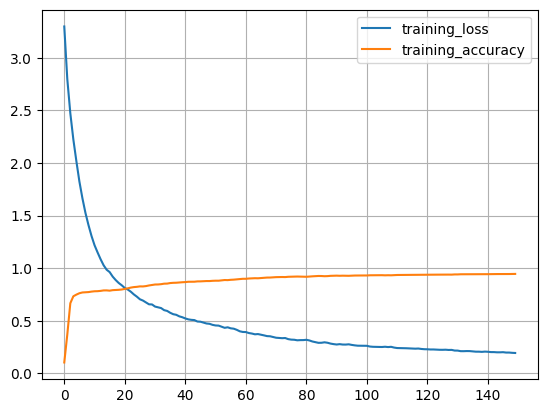

In [19]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

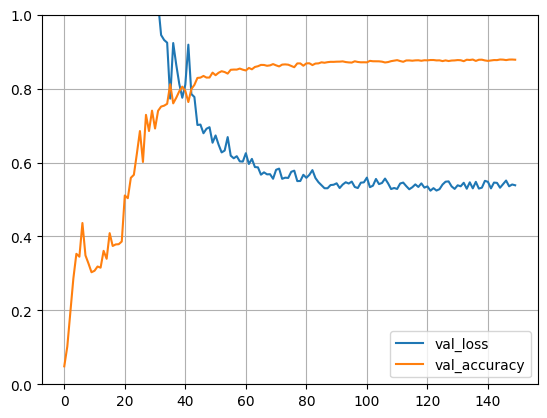

In [22]:
plt.plot(retVal.history['val_loss'], label = 'val_loss')
plt.plot(retVal.history['val_accuracy'], label = 'val_accuracy')
plt.ylim((0,1))
plt.legend()
plt.grid(True)

In [23]:
## function for getting 16 predictions
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img']
    mask = valMap['mask']
    mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img[0:16])
    
    predictions_softmax = model.predict(imgProc)
    predictions = np.empty((16,256,256,3))
    
    for k in range(16) :
        for i in range(256) :
            for j in range(256) :
                predictions[k][i][j] = labeltoRGB(rgb_dict,predictions_softmax[k][i][j].argmax())
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, imgProc, mask
    

    
    
def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(7,7))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask.astype('int64'))
    plt.title('Predicted Mask')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('actual Mask')
    
    
    
    

In [24]:
sixteenPrediction, actuals, masks = predict16(framObjValidation, myTransformer)

1/1 [==============================] - 2s 2s/step


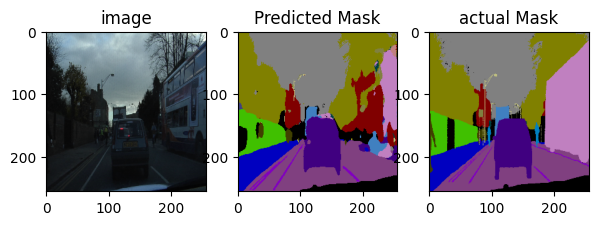

In [26]:
Plotter(actuals[1], sixteenPrediction[1], masks[1])

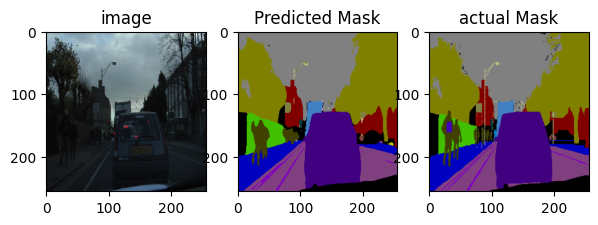

In [27]:
Plotter(actuals[2], sixteenPrediction[2], masks[2])

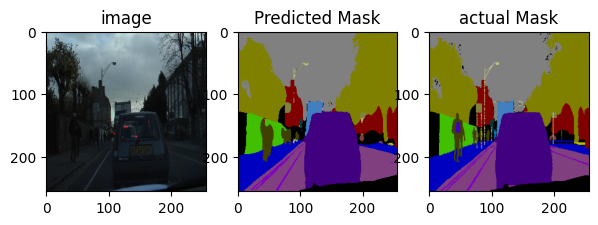

In [28]:
Plotter(actuals[3], sixteenPrediction[3], masks[3])

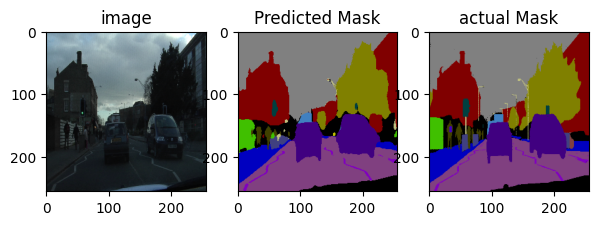

In [29]:
Plotter(actuals[4], sixteenPrediction[4], masks[4])

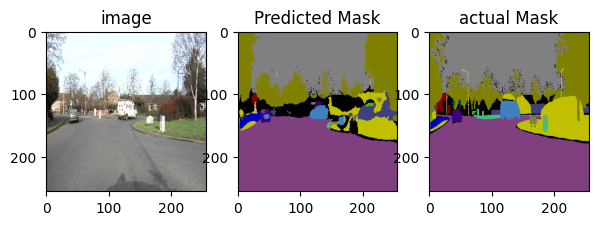

In [30]:
Plotter(actuals[9], sixteenPrediction[9], masks[9])

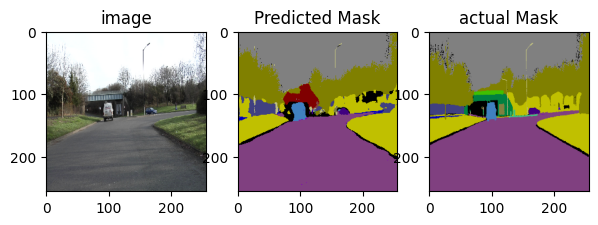

In [31]:
Plotter(actuals[11], sixteenPrediction[11], masks[11])

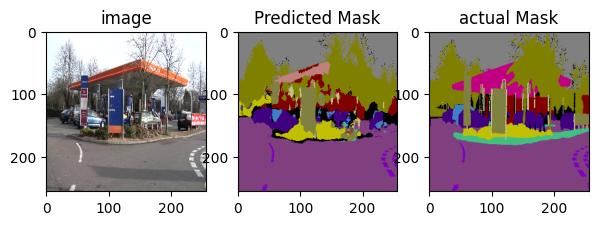

In [32]:
Plotter(actuals[14], sixteenPrediction[14], masks[14])

## prediction and IOU score

In [33]:
from tensorflow import keras
model = tf.keras.models.load_model('Unet_attention')


In [34]:
#for metric evaluation
def predictAll (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img']
    mask = valMap['mask']
    #mask = mask[0:16]
    
    #imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions_softmax = model.predict(imgProc)
    predictions = np.empty((100,256,256,1))
    
    for k in range(100) :
        for i in range(256) :
            for j in range(256) :
                predictions[k][i][j] = predictions_softmax[k][i][j].argmax()
    
    
    return predictions, imgProc, mask
    

In [35]:
Prediction, actuals, masks = predictAll(framObjValidation, model)


4/4 [==============================] - 1s 137ms/step


In [36]:
#get label for all pixels

predicted_label_list = []
true_label_list = []
for k in range(100) : #img #
    for i in range(256) : 
        for j in range(256) : #get rgb pixels
            predicted_label_list.append(int(Prediction[k][i][j][0]))
            true_label_list.append(RGBtolabel(masks[k][i][j]*255,label))



In [37]:
from sklearn import metrics
from sklearn.metrics import classification_report
y_true = true_label_list
y_pred = predicted_label_list



In [38]:
iou_score_list = []
for i in range(32) :
    m = tf.keras.metrics.IoU(num_classes=32, target_class_ids=[i])
    m.update_state(y_pred=y_pred,y_true=y_true)
    iou_score_list.append( m.result().numpy())


In [39]:
class_name = pd.read_csv('CamVid/class_dict.csv',usecols=[0])
class_name

,name
0,Animal
1,Archway
2,Bicyclist
3,Bridge
4,Building
5,Car
6,CartLuggagePram
7,Child
8,Column_Pole
9,Fence


In [40]:
iou_score_list

[0.0,
 0.0,
 0.6198808,
 0.0,
 0.84376377,
 0.72347516,
 0.0,
 0.0,
 0.077732675,
 0.46656626,
 0.60780036,
 0.0,
 0.20929974,
 0.0,
 0.2052453,
 0.18707167,
 0.21372832,
 0.9315957,
 0.46344167,
 0.8020962,
 0.082718216,
 0.92015064,
 0.29951364,
 0.0,
 0.3937066,
 0.0,
 0.7448438,
 0.23946287,
 0.0,
 0.48090255,
 0.25567293,
 0.5579187]

In [41]:
class_name['iou_score'] = iou_score_list

In [44]:
class_name.to_excel('iou_score_unet_attention.xlsx')

## classification report

In [43]:
class_report = classification_report(y_true=y_true,y_pred=y_pred)
print(class_report)

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8124
           1       0.00      0.00      0.00     14534
           2       0.89      0.67      0.77     31137
           3       0.00      0.00      0.00      1791
           4       0.90      0.93      0.92   1461737
           5       0.82      0.86      0.84    237769
           6       0.00      0.00      0.00      4592
           7       0.00      0.00      0.00      4554
           8       0.40      0.09      0.14     58681
           9       0.73      0.57      0.64     86465
          10       0.76      0.76      0.76    111325
          11       0.00      0.00      0.00      3231
          12       0.47      0.27      0.35     55250
          13       0.00      0.00      0.00       398
          14       0.56      0.24      0.34     33600
          15       0.57      0.22      0.32     15710
          16       0.44      0.29      0.35     50326
          17       0.96    

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
